# Basics of Mobile Robotics Project 2020

#### Members: Kevin Qiu, Celinna Ju, Joachim Honeggar, Mike

## 1. Environment


Due to the limited resolution of the webcam we had, we decided to use a fairly small map as the environment. The map is constructed out of white paper, and the obstacles are made of black paper. A picture of the map is take using the webcam. Since the camera sees the map at a slight angle, the corners of the map are detected and the image is flattened. The image before and after the flattening is shown below ADD

In [ ]:
# Insert map image

## 2. Path Planning

We decided to use Voronoi for path planning because it ensures that the robot does not hit any objects. 

In [5]:
import os
import sys
import math
import numpy as np
import matplotlib.pyplot as plt
import cv2

sys.path.append(os.getcwd() + '/global_nav')
sys.path.append(os.getcwd() + '/camera')

from dijkstra_search import DijkstraSearch
from scipy.spatial import cKDTree, Voronoi

The following code was retrieved from https://pythonrobotics.readthedocs.io/en/latest/modules/path_planning.html. The values N_KNN and MAX_EDGE_LEN can be configured.

In [2]:
class VoronoiRoadMapPlanner:

    def __init__(self):
        # parameter
        self.N_KNN = 10  # number of edge from one sampled point
        self.MAX_EDGE_LEN = 30.0  # [m] Maximum edge length

    def planning(self, sx, sy, gx, gy, ox, oy, robot_radius):
        obstacle_tree = cKDTree(np.vstack((ox, oy)).T)

        sample_x, sample_y = self.voronoi_sampling(sx, sy, gx, gy, ox, oy)
        if show_animation:  # pragma: no cover
            plt.plot(sample_x, sample_y, ".b")

        road_map_info = self.generate_road_map_info(
            sample_x, sample_y, robot_radius, obstacle_tree)

        rx, ry = DijkstraSearch(show_animation).search(sx, sy, gx, gy,
                                                       sample_x, sample_y,
                                                       road_map_info)
        return rx, ry

    def is_collision(self, sx, sy, gx, gy, rr, obstacle_kd_tree):
        x = sx
        y = sy
        dx = gx - sx
        dy = gy - sy
        yaw = math.atan2(gy - sy, gx - sx)
        d = math.hypot(dx, dy)

        if d >= self.MAX_EDGE_LEN:
            return True

        D = rr
        n_step = round(d / D)

        for i in range(n_step):
            dist, _ = obstacle_kd_tree.query([x, y])
            if dist <= rr:
                return True  # collision
            x += D * math.cos(yaw)
            y += D * math.sin(yaw)

        # goal point check
        dist, _ = obstacle_kd_tree.query([gx, gy])
        if dist <= rr:
            return True  # collision

        return False  # OK

    def generate_road_map_info(self, node_x, node_y, rr, obstacle_tree):
        """
        Road map generation

        node_x: [m] x positions of sampled points
        node_y: [m] y positions of sampled points
        rr: Robot Radius[m]
        obstacle_tree: KDTree object of obstacles
        """

        road_map = []
        n_sample = len(node_x)
        node_tree = cKDTree(np.vstack((node_x, node_y)).T)

        for (i, ix, iy) in zip(range(n_sample), node_x, node_y):

            dists, indexes = node_tree.query([ix, iy], k=n_sample)

            edge_id = []

            for ii in range(1, len(indexes)):
                nx = node_x[indexes[ii]]
                ny = node_y[indexes[ii]]

                if not self.is_collision(ix, iy, nx, ny, rr, obstacle_tree):
                    edge_id.append(indexes[ii])

                if len(edge_id) >= self.N_KNN:
                    break

            road_map.append(edge_id)

            #plot_road_map(road_map, sample_x, sample_y)

        return road_map

    @staticmethod
    def plot_road_map(road_map, sample_x, sample_y):  # pragma: no cover

        for i, _ in enumerate(road_map):
            for ii in range(len(road_map[i])):
                ind = road_map[i][ii]

                plt.plot([sample_x[i], sample_x[ind]],
                         [sample_y[i], sample_y[ind]], "-k")

    @staticmethod
    def voronoi_sampling(sx, sy, gx, gy, ox, oy):
        oxy = np.vstack((ox, oy)).T

        # generate voronoi point
        vor = Voronoi(oxy)
        sample_x = [ix for [ix, _] in vor.vertices]
        sample_y = [iy for [_, iy] in vor.vertices]

        sample_x.append(sx)
        sample_y.append(sy)
        sample_x.append(gx)
        sample_y.append(gy)

        return sample_x, sample_y

The flattened image is passed into the get_path() function to get the x,y coordinates of the voronoi path. The start and goal positions, along with the robot_size, are configured in mm. We must make sure that these values are within the map and corresponds to empty spaces in the map. Scaling factors are used to convert the pixel values of the input image to real life distances in mm. 

In [29]:
def get_path(img,show_animation, add_border):
    print("Voronoi path planning starting...")
    # start and goal position
    sx = 5.0  # [mm]
    sy = 5.0  # [mm]
    gx = 50.0  # [mm]
    gy = 20.0  # [mm]
    robot_size = 2.0  # [mm]
    
    # Factors to convert pixels to real life distance units (mm)
    pixel2mmx = 2.56
    pixel2mmy = 2.14
    
    # Scaling factor
    factor = 20 # Used to reduce the density of points in the map to reduce calculation time and simplify path
    
    # Process image
    
    row, col = gray.shape[:2]

    # Add border to image if there isn't any
    if add_border:
        bordersize = 5
        border = cv2.copyMakeBorder(
            gray,
            top=bordersize,
            bottom=bordersize,
            left=bordersize,
            right=bordersize,
            borderType=cv2.BORDER_CONSTANT,
            value=[0, 0, 0]
        )

        #print(border.shape)
    
    h,w = border.shape
    
    new_img = cv2.resize(border,(int(pixel2mmy*w/factor), int(pixel2mmx*h/factor))) 
    
    ret, thresh = cv2.threshold(new_img,127,255,cv2.THRESH_BINARY_INV)

    thresh = np.rot90(thresh,k=1, axes=(1,0))
    #thresh = cv2.flip(thresh,0)
    
    coords = np.column_stack(np.where(thresh == 255))
    coords = np.transpose(coords)
    
    ox = coords[0,:]
    ox = ox.tolist()
    
    oy = coords[1,:]
    oy = oy.tolist()
    
    if show_animation:  # pragma: no cover
        plt.plot(ox, oy, ".k")
        plt.plot(sx, sy, "^r")
        plt.plot(gx, gy, "^c")
        plt.grid(True)
        plt.axis("equal")

    rx, ry = VoronoiRoadMapPlanner().planning(sx, sy, gx, gy, ox, oy,
                                              robot_size)
    assert rx, 'Cannot found path'
    
    if show_animation:  # pragma: no cover
        plt.plot(rx, ry, "-r")
        plt.pause(0.1)
        #plt.show()

    # Convert scaled value back to mm values in integer format
    rx = (np.array(rx)*factor).astype(int)
    ry = (np.array(ry)*factor).astype(int)

    return rx, ry

Voronoi path planning starting...


<IPython.core.display.Javascript object>


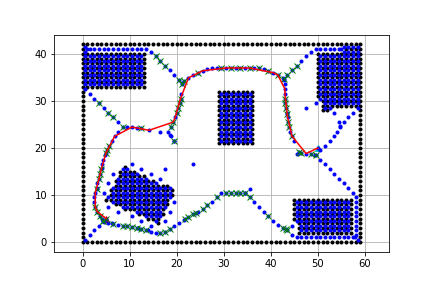

goal is found!
[ 100   62   54   54   70   80  100  136  210  282  385  393  416  450
  510  610  710  810  830  860  860  868  871  890  950 1000]


In [30]:
%matplotlib notebook

# Name of image to load
im = 'camera/warped-img.jpg'
img = cv2.imread(im, cv2.IMREAD_GRAYSCALE) # read in gray scale

#gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#cv2.imshow('hi',img)
#cv2.waitKey(0)
#cv2.destroyAllWindows()

show_animation = True
add_border = True # add border to image if there isn't any

rx, ry = get_path(img, show_animation, add_border)

#print(rx)

Trajectory is superimposed onto camera view for visualization.

## 3. Motion Control & Filtering

In [ ]:
# Add description 
# Can call .py file

## 4. Avoid Obstacles

In [ ]:
# Add description
# Can call .py file

## Dicussion and Conclusion

In [ ]:
# Add description
# Can call .py file